# Training a neural network on the Fashion MNIST dataset

The **Fashion MNIST** dataset is a popular benchmark dataset used for evaluating machine learning and deep learning models, especially for classification tasks involving image data. It's intended as a more challenging and realistic replacement for the original MNIST dataset of handwritten digits.

### Key Facts:

* **Published by**: Zalando Research
* **Number of classes**: 10
* **Total samples**: 70,000 grayscale images (60,000 for training, 10,000 for testing)
* **Image size**: 28x28 pixels
* **Image type**: Grayscale (1 channel)
* **File format**: Same structure and format as original MNIST

### The 10 Fashion Categories:

Each image corresponds to one of the following classes:

1. T-shirt/top
2. Trouser
3. Pullover
4. Dress
5. Coat
6. Sandal
7. Shirt
8. Sneaker
9. Bag
10. Ankle boot

Each label is a number from 0 to 9 corresponding to the above categories.

### Why use Fashion MNIST?

* It has the **same dimensions and format** as MNIST, so it’s easy to switch with minimal code changes.
* It is **more complex** than digit recognition, making it a better test of model performance.
* It is widely used in **deep learning tutorials and research papers** as a benchmark dataset.

### Model setup

We are facing here a multi class classification model.

Dataset samples are 28x28 pixels grayscale images. So each we treat each pixel as an input feature, we have 784 input features that are values between 0 and 255.

Each sample is associated a class label between 0 and 9 (10 classes).

With this setup, we will likely use a deep neural network for multi class classification using the softmax function as our output function (and to compute the cross entropy loss with multiple classes).

Let's start by visualizing our dataset.

### Setup

In [3]:
# Install dependencies as needed:
%pip install pandas
%pip install matplotlib
%pip install numpy
%pip install torch
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
#Import dependencies
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import random_split
from torch.utils.data import TensorDataset
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

## Importing the dataset

In [5]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

## Visualize the data

In [6]:
print(training_data)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [7]:
image_tensor, label = training_data[0]

print(label)

print(image_tensor)

9
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.000

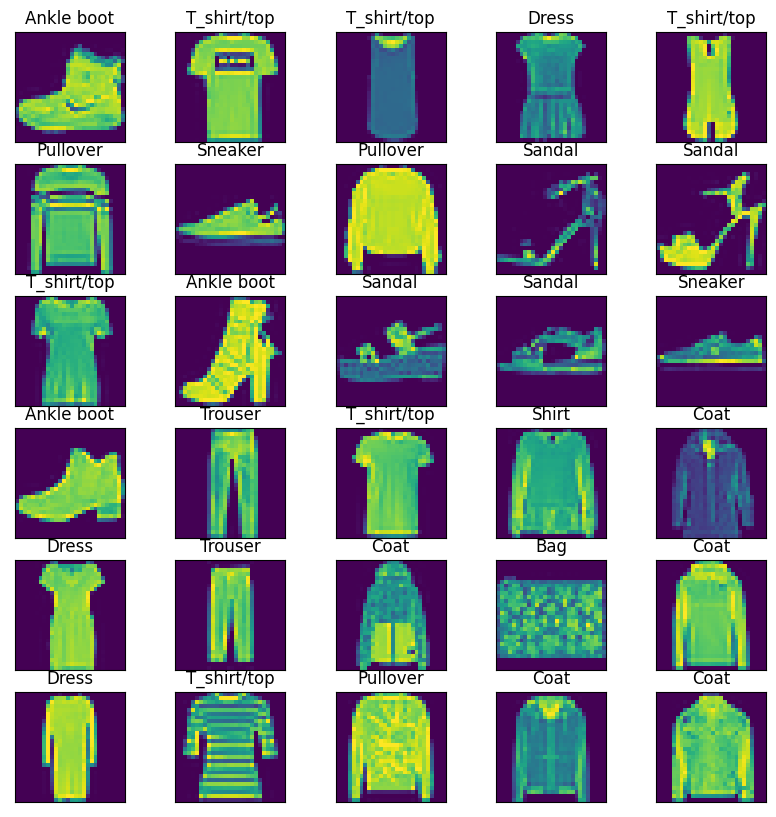

In [8]:
class_names = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize = (10,10))

for i in range(0,30):
  
    plt.subplot(6,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid=False

    image_tensor, class_index = training_data[i]
    array = image_tensor.numpy()
    sample_img = array.reshape((28,28))
    
    plt.imshow(sample_img)
    
    plt.title(class_names[class_index])

## Preprocessing

We will perform Z-score normalization on the dataset. In our case it helps:
1. **Stabilizes training**: Prevents the gradients from becoming too small or too large (which could lead to vanishing or exploding gradients).
2. **Faster convergence**: Well-scaled inputs allow the optimization algorithm to make more consistent updates.
3. **Improves generalization**: Reduces overfitting and ensures that the model can handle unseen data better.

In [9]:
def dataset_to_arrays(dataset):
    images = []
    labels = []
    
    for img, label in dataset:
        img_array = np.array(img)  # Converts PIL Image to NumPy array (28x28)
        images.append(img_array.flatten())  # Flatten to 1D
        labels.append(label)

    return images, labels

images_train, labels_train = dataset_to_arrays(training_data)
images_test, labels_test = dataset_to_arrays(test_data)
X_train = np.stack(images_train)  # Shape: (N, 784)
y_train = np.array(labels_train)

X_test = np.stack(images_test)  # Shape: (N, 784)
y_test = np.array(labels_test)

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
print(X_test_scaled.shape)

(10000, 784)


In [12]:
X_train_tensor_scaled = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor_scaled = torch.tensor(y_train, dtype=torch.long)

X_test_tensor_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor_scaled = torch.tensor(y_test, dtype=torch.long)

training_set = TensorDataset(X_train_tensor_scaled, y_train_tensor_scaled)
test_set = TensorDataset(X_test_tensor_scaled, y_test_tensor_scaled)

## Defining hyperparameters

In [30]:
image_tensor, label = training_set[0]
input_dim = image_tensor.shape[0]
output_dim = 10

dev_set_split = 0.5

layers_dims = [input_dim, 64, output_dim]
layers_activations = [nn.ReLU(), None]

batch_size=64

learning_rate=1e-3
momentum=0.9

end_training_threshold = 1e-3

## Splitting dev/test sets

In [14]:
N = len(test_set)
dev_size = int(dev_set_split * N)
test_size = N - dev_size

generator = torch.Generator().manual_seed(42)
dev_set, test_set = random_split(test_set, [dev_size, test_size], generator=generator)

## Creating DataLoaders

In order to pass our data to our neural network, we have to put it in the right format.

A `DataLoader` is a PyTorch utility that **automatically manages how your dataset is fed to the model** during training/testing.

It **wraps** your dataset and:
- Divides it into **mini-batches**
- **Shuffles** the data (if you want)
- **Loads** it efficiently (can even load in **parallel** with multiple worker threads)
- **Handles** going through the whole dataset multiple times (epochs)

We use them for:

1. **Mini-batch training**  
   - Training with the full dataset at once is inefficient or impossible (memory!).  
   - Training sample-by-sample is too slow.  
   → Solution: **batch** samples.

2. **Shuffling**  
   - Shuffling helps **break correlations** in the dataset, improving generalization.

3. **Efficiency**  
   - Can load data **in parallel** while the GPU is busy training on a previous batch (`num_workers > 0`).

4. **Code simplicity**  
   - Instead of manually slicing arrays, you just write:
     ```python
     for batch in dataloader:
         ...
     ```

In [15]:
# Create data loaders.
train_dataloader = DataLoader(training_set, batch_size=batch_size)
dev_dataloader = DataLoader(dev_set, batch_size=batch_size)
test_dataloader = DataLoader(test_set, batch_size=batch_size)

for X, y in train_dataloader:
    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X: torch.Size([64, 784])
Shape of y: torch.Size([64]) torch.int64


## Build our neural network

We will start with the following simple network architecture:

- Input layer: 784 input units for the 784 input pixels of each image.
- Hidden layers: we will start with one hidden layer with 64 units.
- Output layer: 10 units for the 10 digit classes output probability.

We define our loss function (Cross Entropy Loss) as well as an optimizer to perform gradient descent (SGD with momentum).

In [31]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [38]:
class NeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, activations):
        """
        layer_sizes: list of integers, e.g. [784, 256, 128, 10]
        activations: list of activation functions (nn.Module), len = len(layer_sizes) - 1
        """
        super().__init__()

        layers = []
        for i in range(len(layer_sizes) - 1):
            in_features = layer_sizes[i]
            out_features = layer_sizes[i + 1]
            layers.append(nn.Linear(in_features, out_features))
            if activations[i] is not None:
                layers.append(activations[i])

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [39]:
model = NeuralNetwork(layers_dims, layers_activations).to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

NeuralNetwork(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)


## Training our model

Now let's implement our training function that will iterate through the mini-batches of our DataLoader and each time perform the following steps:
- Compute the predicted values.
- Compute the loss for our predicted values.
- Perform backpropagation using the loss.backward() function that will compute the gradient for each parameter of the model.
- Run one optimization step using the optimizer we defined.

In [34]:
def train_epoch(train_dataloader, model, loss_fn, optimizer):
    size = len(train_dataloader.dataset)
    total_loss = 0.0
    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss+=loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    average_loss = total_loss/len(train_dataloader)
    print(f"Average training loss: {average_loss}")
    return average_loss

Let's define a test function that will run the model on our test data and measure how good it does (computing average loss and accuracy on the test data).

In [35]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Now we're ready to run training!

In [36]:
def train_model(model, loss_fn, optimizer, train_dataloader, dev_dataloader, end_training_threshold):
    epoch = 1
    previous_average_loss = None
    while True:
        print(f"Epoch {epoch}\n-------------------------------")
        epoch_average_training_loss = train_epoch(train_dataloader, model, loss_fn, optimizer)

        print(f"Training performance for current epoch")
        test(train_dataloader, model, loss_fn)

        print(f"Dev performance for current epoch")
        test(dev_dataloader, model, loss_fn)
        
        change_in_average_loss = np.inf if not previous_average_loss else previous_average_loss - epoch_average_training_loss
        print(f"Change in average loss: {change_in_average_loss}")
        if(change_in_average_loss and change_in_average_loss > 0 and change_in_average_loss < end_training_threshold): break
        previous_average_loss = epoch_average_training_loss
        epoch+=1
        
    print("TRAINING DONE!")

In [37]:
train_model(model, loss_fn, optimizer, train_dataloader, dev_dataloader, end_training_threshold)

Epoch 1
-------------------------------
loss: 2.267593  [   64/60000]
loss: 1.267373  [ 6464/60000]
loss: 0.719086  [12864/60000]
loss: 0.899726  [19264/60000]
loss: 0.676065  [25664/60000]
loss: 0.654656  [32064/60000]
loss: 0.596075  [38464/60000]
loss: 0.631905  [44864/60000]
loss: 0.667214  [51264/60000]
loss: 0.555026  [57664/60000]
Average training loss: 0.7578288701170289
Training performance for current epoch
Error: 
 Accuracy: 82.2%, Avg loss: 0.500888 

Dev performance for current epoch
Error: 
 Accuracy: 81.6%, Avg loss: 0.522420 

Change in average loss: inf
Epoch 2
-------------------------------
loss: 0.413704  [   64/60000]
loss: 0.530964  [ 6464/60000]
loss: 0.339655  [12864/60000]
loss: 0.615319  [19264/60000]
loss: 0.483520  [25664/60000]
loss: 0.479051  [32064/60000]
loss: 0.450016  [38464/60000]
loss: 0.584514  [44864/60000]
loss: 0.625548  [51264/60000]
loss: 0.462038  [57664/60000]
Average training loss: 0.46306607818234957
Training performance for current epoch
E

### Diagnose of our training

Now that we're done training, we can analyse the performance of our model both on the training set and the dev set.

Training accuracy: 95.9%
Dev accuracy: 88.9%

From these two values, we can see that we are doing pretty good on the training data, but more poorly on the dev set. This indicates our model suffers from high variance (overfitting).

Let's try using a smaller network (a simpler model) to see if it helps reducing overfitting while keeping good performance on the training set.

In [45]:
layers_dims = [input_dim, 32, output_dim]
layers_activations = [nn.ReLU(), None]

model = NeuralNetwork(layers_dims, layers_activations).to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

NeuralNetwork(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [46]:
train_model(model, loss_fn, optimizer, train_dataloader, dev_dataloader, end_training_threshold)

Epoch 1
-------------------------------
loss: 2.288157  [   64/60000]
loss: 1.235242  [ 6464/60000]
loss: 0.672514  [12864/60000]
loss: 0.901535  [19264/60000]
loss: 0.695214  [25664/60000]
loss: 0.677244  [32064/60000]
loss: 0.612013  [38464/60000]
loss: 0.601675  [44864/60000]
loss: 0.666102  [51264/60000]
loss: 0.586080  [57664/60000]
Average training loss: 0.7640148355508409
Training performance for current epoch
Error: 
 Accuracy: 81.6%, Avg loss: 0.510036 

Dev performance for current epoch
Error: 
 Accuracy: 80.8%, Avg loss: 0.531903 

Change in average loss: inf
Epoch 2
-------------------------------
loss: 0.405024  [   64/60000]
loss: 0.535282  [ 6464/60000]
loss: 0.315106  [12864/60000]
loss: 0.606443  [19264/60000]
loss: 0.488605  [25664/60000]
loss: 0.492738  [32064/60000]
loss: 0.441893  [38464/60000]
loss: 0.575523  [44864/60000]
loss: 0.608279  [51264/60000]
loss: 0.466340  [57664/60000]
Average training loss: 0.4677850847273493
Training performance for current epoch
Er

To fix that, we can add regularization to our loss function.

### One hidden layer with regularization

In [40]:
model = NeuralNetwork(layers_dims, layers_activations).to(device)
print(model)

weight_decay = 1e-4

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)

NeuralNetwork(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [41]:
train_model(model, loss_fn, optimizer, train_dataloader, dev_dataloader, end_training_threshold)

Epoch 1
-------------------------------
loss: 2.316161  [   64/60000]
loss: 1.182007  [ 6464/60000]
loss: 0.661612  [12864/60000]
loss: 0.883894  [19264/60000]
loss: 0.686040  [25664/60000]
loss: 0.663665  [32064/60000]
loss: 0.593773  [38464/60000]
loss: 0.632216  [44864/60000]
loss: 0.655966  [51264/60000]
loss: 0.577709  [57664/60000]
Average training loss: 0.7552932457629044
Training performance for current epoch
Error: 
 Accuracy: 82.0%, Avg loss: 0.506807 

Dev performance for current epoch
Error: 
 Accuracy: 81.0%, Avg loss: 0.527547 

Change in average loss: inf
Epoch 2
-------------------------------
loss: 0.409752  [   64/60000]
loss: 0.529091  [ 6464/60000]
loss: 0.351718  [12864/60000]
loss: 0.629278  [19264/60000]
loss: 0.476292  [25664/60000]
loss: 0.500463  [32064/60000]
loss: 0.438405  [38464/60000]
loss: 0.577945  [44864/60000]
loss: 0.600128  [51264/60000]
loss: 0.466588  [57664/60000]
Average training loss: 0.46700824296741344
Training performance for current epoch
E

### More regularization

It seems like 1e-4 weight decay didn't really impact the overfitting.
Let's try bigger values.

In [42]:
model = NeuralNetwork(layers_dims, layers_activations).to(device)
print(model)

weight_decay = 1e-3

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)

NeuralNetwork(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [43]:
train_model(model, loss_fn, optimizer, train_dataloader, dev_dataloader, end_training_threshold)

Epoch 1
-------------------------------
loss: 2.363905  [   64/60000]
loss: 1.252863  [ 6464/60000]
loss: 0.704967  [12864/60000]
loss: 0.865815  [19264/60000]
loss: 0.667265  [25664/60000]
loss: 0.645295  [32064/60000]
loss: 0.604094  [38464/60000]
loss: 0.635680  [44864/60000]
loss: 0.658490  [51264/60000]
loss: 0.569495  [57664/60000]
Average training loss: 0.7501920419397639
Training performance for current epoch
Error: 
 Accuracy: 82.0%, Avg loss: 0.503954 

Dev performance for current epoch
Error: 
 Accuracy: 81.2%, Avg loss: 0.523041 

Change in average loss: inf
Epoch 2
-------------------------------
loss: 0.445585  [   64/60000]
loss: 0.541711  [ 6464/60000]
loss: 0.336069  [12864/60000]
loss: 0.609999  [19264/60000]
loss: 0.483774  [25664/60000]
loss: 0.487954  [32064/60000]
loss: 0.431556  [38464/60000]
loss: 0.603316  [44864/60000]
loss: 0.605457  [51264/60000]
loss: 0.458329  [57664/60000]
Average training loss: 0.46449921548620726
Training performance for current epoch
E

### Increasing regularization

In [29]:
model = NeuralNetwork(layers_dims, layers_activations).to(device)
print(model)

weight_decay = 1e-3

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)

NeuralNetwork(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)
